## Collaboration and Competition Project

![](https://user-images.githubusercontent.com/10624937/42135623-e770e354-7d12-11e8-998d-29fc74429ca2.gif)

- More info about the purpose of the project can be read here : [Udacity Project link](https://github.com/udacity/deep-reinforcement-learning/tree/master/p3_collab-compet)


## Prerequisites

- Create a python env as described here: https://github.com/udacity/deep-reinforcement-learning/tree/master/python

- Download the project structure here : [github](https://github.com/antoniopenta/deep_reinforcement_learning/tree/master/drl_multiagent_rl)


- You need to download the unity env Tennis at the following link (Mac) and save it (unzipped) in the env folder of the main project: https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis.app.zip


- **AWS configuration**, the code has been runned on the AWS instance using GPU.
    - To AWS instance (p2.xlarge) is the Deep Learning AMI with Source Code (CUDA 8, Ubuntu) (you can search it on the AWS Marketplace). I have used the credit from the Udacity course.
    -  The configuration is well explained in the extra curriculm activities (you can find notes with more details in aws.txt file saved within this repository).

- For AWS, the unity env can be downloaded [here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Linux_NoVis.zip), You will not be able to watch the agent without enabling a virtual screen, but you will be able to train the agent.
    
 


## Project Structure

- The project has these foldes:
    - **data**: it contains data that are created during the execution
    - **framework**: it contain the code for the networks,agent,and cordinator 
    - **env**: where the unity env is store
    - **model**: where the checkpoint for the network is saved
    
     

## Problem Description
This project uses **Tennis** Unity environment. 

- In this environment, two agents control rackets to bounce a ball over a net. 
- If an agent hits the ball over the net, it receives a reward of +0.1. 
- If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.
- Thus, the goal of each agent is to keep the ball in play.
- The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. - - Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.


## What is the main approach
- The code algorithm is Deep Deterministic Policy Gradient (DDPG), which is based on the Policy Gradient approach.
- The core idea of the algorithm is described in the Udacity videos [video1](https://youtu.be/0NVOPIyrr98) [video2](https://youtu.be/RT-HDnAVe9o)
- The algorithm is using the Actor-Critic approach. 
- The Actor is a Neural Network that approximates a deterministic policy. It takes in input the state and the output is an array of values, one for each action.
- The Actor is used to approximate the policy ($\pi(a\mid s;\theta_\pi)$).
- In DDPG, the output is deterministic, and it represents the policy value the action space. The outputs are values in the range [-1,1]
- The Critic is used to give feedback about the value of the input state observed by the actor and the action considered in the actor.
- Both Actor and Critic have a target and regular networks. The target network is used to define the desired target, avoiding to have the same network for considering the prediction and the target. This is the same idea used in the DQN algorithm.
- In the DDPG algorithm, there is a soft update approach, which means that the target network is updated more often but with a smaller change.
- The DDPG is a policy gradient algorithm, this kind of algorithms suffers from having large variance, due to their Monte Carlo approach in computing the cumulative reword.
- To reduce the variance, a Temporal Difference approach is used together with bootstrapping, this approach reduces the variance but introduce a bias.
- The exploration of the action space is done by injecting the noise in the last layer of the Actor Network.

## Algorithm Explanation

- A list of agents is created, the agents share the critic network (main_script_maddpg_train.py)
- The network stucture is defiend in network.py
- The agent functions are defined in the class **class DDPGAgent()** in agent.py
- A coordinator is used to send tasks to the agents (**class MADDPGCoordinator()** in coordinator.py)
- This is the main loop for the training in main_script_maddpg_train.py:

```python
    for i_episode in range(0, config.num_episodes):

        env_info = env.reset(train_mode=True)[brain_name]
        # get the observation
        states = env_info.vector_observations
        # reset the noise of each agent
        maddpg.reset_noise()
        # used to store results
        scores = np.zeros(num_agents)

        for t_step in range(config.max_steps_4_episodes):

            # get the actions from the agent using their local network
            actions = maddpg.agents_act(states, exploration=exploration_eps)
            #run the actions
            env_info = env.step(actions)[brain_name]  # send the action to the environment
            #get the result
            next_states = env_info.vector_observations  # get the next state
            rewards = env_info.rewards  # get the reward
            dones = env_info.local_done
            #save the result in the buffer
            maddpg.remember(states, actions, rewards, next_states, dones)
            #make a step
            maddpg.step(t_step)
            # update sarsa
            states = next_states
            scores += rewards
            # reduce explortion
            exploration_eps = exploration_strategy_1(exploration_eps, config)

            if np.any(dones):
                break


        score = np.max(scores)
```
- **Comments**:

    - the **exploration_strategy_1(exploration_eps, config)** uses a decay of the exploration eps starting from 2 until 0.05, the parameters are in the config class.
    - the **maddpg.remember(states, actions, rewards, next_states, dones)** stores the sarsa observations in the central buffer.
    - the learning (if conditions are satisfied) is done in **maddpg.step(t_step)**.
    - the noise can be injected in the action prediction from the network (method **def local_act(self, state,exploration=1,add_noise=True)** in class DDPGAgent() in agent.py)
    - the noise is progressively (muliply by a decay value) smoothed using the scalar exploration_eps

- **Learning**:
    - The learning is done  if t_step % self.config.ddpg_update_every (self.config.ddpg_update_every value is set to 2, so each odd number), this is done in the **def step(self,t_step)** metod in class MADDPGCoordinator() in coordinator.py )
    - The learning is done muliple times for each agent using different sarsa tuples (**def step(self,t_step)** method in class MADDPGCoordinator() in coordinator.py )
    - The learning (updated of the weights) is based on the [deterministic deep policy gradient](http://proceedings.mlr.press/v32/silver14.pdf) approach and it is done in **def learn(self, experiences, gamma)**,  in the class DDPGAgent() in agent.py.
   - After updating the weights of the network a soft upated is applied between the actor and the critic (** def soft_update(self, local_model, target_model, tau)** in  class DDPGAgent() in agent.py.
    


## Networks descriptions

- The env is returning a tuple (states,actions,next_states,rewards,dones), where each value of the tuple contains both the values for agent 1 and two, but *each agent is using only its related(state,action,next_state,reward,done)*

- The structure of the **Actor network** (3 hidden layers) is the following:
     - first hidden layer state_dimension * 128
     - second hidden layer 128 * 64
     - third hidden layer 128 * 2
     - ReLu is used as non lineartiy
     - tangh is used to keep the value in [-1,1]
     - if the noise is added to the action, then I used the torch.clam(value,-1,1) to kee the value in [-1,1]
        
- The structure of the **Critic network** (3 hidden layers) is the following:
     - first hidden layer state_dimension * 128
     - second hidden layer 128 + 2(action) * 64
     - third hidden layer 128 * 1
     - ReLu is used as non lineartiy

- All the networks are using a different ADAM optimizer instance

## What has been changed from the classic DDPG 
- The code is based on the DDPG algorithm with the following modification:
     - **central cordinator**, there is a cordinator between the two angents, which has the role to send requests to the agents and to manage a central buffer 
     - **updating the networks** multiple times during one episode
     - **repating the learning steps** multiple times after sampling the buffer
     - **gradient clip** for critic has suggested in the course (torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1))
     - **shared buffer/networks**, two agents share the same buffer/networks,stored in the cordinator. (this has been inspired by the following [github-repos](https://github.com/hortovanyi/DRLND-Collab-Compete)
     - **agents share the same critic**, the two agents share the same critic. (this has been inspired by the following [github-repos](https://github.com/hortovanyi/DRLND-Collab-Compete)
     

## Scripts to Run 

- There are two main scripts in the main foler:
    - main_script_ddpg_test.py, which is used to see the agents in action loading the weights of the networks that have been learned during the train
    - main_script_ddpg_train.py, which is used to train the agent

- Example of output when you run the main_script_dq_train.py :

```sh
/Users/antonio.penta/Documents/virtualenv/drl_multiagent_rl/bin/python /Users/antonio.penta/Documents/workspace/python/deep_reinforcement_learning/drl_multiagent_rl/main_script_maddpg_train.py
Mono path[0] = '/Users/antonio.penta/Documents/workspace/python/deep_reinforcement_learning/drl_multiagent_rl/env/Tennis.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/antonio.penta/Documents/workspace/python/deep_reinforcement_learning/drl_multiagent_rl/env/Tennis.app/Contents/MonoBleedingEdge/etc'
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 
Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
Episode 0	 Average Score : 0.0000	 Eps: 1.97 ,Length Episode   14
Episode 50	 Average Score : 0.0000	 Eps: 0.9644 ,Length Episode   13
Episode 100	 Average Score : 0.0028	 Eps: 0.4415 ,Length Episode   13
Episode 150	 Average Score : 0.0294	 Eps: 0.1167 ,Length Episode   42
Episode 200	 Average Score : 0.0876	 Eps: 0.05 ,Length Episode   29
Episode 250	 Average Score : 0.1286	 Eps: 0.05 ,Length Episode   56
Episode 300	 Average Score : 0.3924	 Eps: 0.05 ,Length Episode   90

Environment solved in 212 episodes!	Average Score: 0.50

Environment solved in 213 episodes!	 Best Average Score: 0.53

Environment solved in 214 episodes!	 Best Average Score: 0.54

Environment solved in 215 episodes!	 Best Average Score: 0.55

Environment solved in 216 episodes!	 Best Average Score: 0.55

Environment solved in 219 episodes!	 Best Average Score: 0.57

Environment solved in 220 episodes!	 Best Average Score: 0.60

Environment solved in 221 episodes!	 Best Average Score: 0.62

Environment solved in 222 episodes!	 Best Average Score: 0.64

Environment solved in 223 episodes!	 Best Average Score: 0.67

Environment solved in 224 episodes!	 Best Average Score: 0.69

Environment solved in 225 episodes!	 Best Average Score: 0.72

Environment solved in 226 episodes!	 Best Average Score: 0.74

Environment solved in 227 episodes!	 Best Average Score: 0.77

Environment solved in 228 episodes!	 Best Average Score: 0.79

Environment solved in 230 episodes!	 Best Average Score: 0.82

Environment solved in 232 episodes!	 Best Average Score: 0.84

Environment solved in 233 episodes!	 Best Average Score: 0.86

Environment solved in 234 episodes!	 Best Average Score: 0.88

Environment solved in 236 episodes!	 Best Average Score: 0.89

Environment solved in 237 episodes!	 Best Average Score: 0.92

Environment solved in 238 episodes!	 Best Average Score: 0.92

Environment solved in 239 episodes!	 Best Average Score: 0.95

Environment solved in 240 episodes!	 Best Average Score: 0.95

Environment solved in 241 episodes!	 Best Average Score: 0.96

Environment solved in 242 episodes!	 Best Average Score: 0.97

Environment solved in 243 episodes!	 Best Average Score: 1.00

Environment solved in 244 episodes!	 Best Average Score: 1.00

Environment solved in 245 episodes!	 Best Average Score: 1.03

Environment solved in 246 episodes!	 Best Average Score: 1.05

Environment solved in 247 episodes!	 Best Average Score: 1.06

Environment solved in 248 episodes!	 Best Average Score: 1.08

Environment solved in 249 episodes!	 Best Average Score: 1.10
Episode 350	 Average Score : 1.1187	 Eps: 0.05 ,Length Episode  597

Environment solved in 250 episodes!	 Best Average Score: 1.12

Environment solved in 251 episodes!	 Best Average Score: 1.13

Environment solved in 252 episodes!	 Best Average Score: 1.15

Environment solved in 253 episodes!	 Best Average Score: 1.15

Environment solved in 254 episodes!	 Best Average Score: 1.16

Environment solved in 255 episodes!	 Best Average Score: 1.17

Environment solved in 256 episodes!	 Best Average Score: 1.17

Environment solved in 257 episodes!	 Best Average Score: 1.19

Environment solved in 258 episodes!	 Best Average Score: 1.19

Environment solved in 259 episodes!	 Best Average Score: 1.20

Environment solved in 260 episodes!	 Best Average Score: 1.21

Environment solved in 261 episodes!	 Best Average Score: 1.21

Environment solved in 263 episodes!	 Best Average Score: 1.21

Environment solved in 264 episodes!	 Best Average Score: 1.21

Environment solved in 265 episodes!	 Best Average Score: 1.22

Environment solved in 266 episodes!	 Best Average Score: 1.23

Environment solved in 267 episodes!	 Best Average Score: 1.25

Environment solved in 268 episodes!	 Best Average Score: 1.27

Environment solved in 269 episodes!	 Best Average Score: 1.29

Environment solved in 270 episodes!	 Best Average Score: 1.32

Environment solved in 271 episodes!	 Best Average Score: 1.34

Environment solved in 277 episodes!	 Best Average Score: 1.34

Environment solved in 278 episodes!	 Best Average Score: 1.35

Environment solved in 279 episodes!	 Best Average Score: 1.35
Episode 400	 Average Score : 1.1567	 Eps: 0.05 ,Length Episode   50
Episode 450	 Average Score : 0.5243	 Eps: 0.05 ,Length Episode  137
Episode 500	 Average Score : 0.3468	 Eps: 0.05 ,Length Episode   52
Episode 550	 Average Score : 0.7016	 Eps: 0.05 ,Length Episode   63
Episode 600	 Average Score : 0.8799	 Eps: 0.05 ,Length Episode  213
Episode 650	 Average Score : 0.9384	 Eps: 0.05 ,Length Episode  218
Episode 700	 Average Score : 0.8113	 Eps: 0.05 ,Length Episode   13
Episode 750	 Average Score : 0.4514	 Eps: 0.05 ,Length Episode   89

Process finished with exit code 0

```

## HyperParameters
- All the HyperParameters are managed in the config class in the folder utils

- I report here the summary :

    - num_episodes = 800  # num_episodes (int): maximum number of training episodesor the score
    - max_steps_4_episodes = 1000  # max_t (int) max length of the time stemps
    - network_random_seed =0
    - actor_fc1_units = 128  # number neurons first layer actor
    - actor_fc2_units = 64 # number neurons second layer actor
    - actor_fc3_units = 32  # number neurons first layer actor , not used
    - critic_fc1_units = 128  # number neurons first layer critic
    - critic_fc2_units = 64 # number neurons second layer critic
    - critic_fc3_units= 32 # number neurons third layer critic, not used
    - actor_non_linearity = F.relu # activation function used in the actor network
    - critic_non_linearity = F.relu # activation function used in the critic network
    - actor_lr = 1e-3 # learning rate of the actor
    - critic_lr = 1e-3  # learning rate of the critic
    - actor_weight_decay = 0.0  # L2 weight decay
    - critic_weight_decay = 0.0  # L2 weight decay
    - noise_seed =0 
    - noise_mu = 0.
    - noise_theta = 0.15
    - noise_sigma =  0.2
    - maddpa_buffer_size = int(1e5)  # replay buffer size
    - maddpa_batch_size = 256  # minibatch size
    - maddpa_buffer_random_seed = 24 # random seed buffer
    - ddpg_updates_per_step = 4 # how many time run update
    - ddpg_update_every = 2  # every n time step do update
    - maddpa_gamma = 0.99  # discount factor
    - maddpa_tau = 1e-2   # for soft update of target parameters
    - exploration_epsilon_max = 2.0 # episilon used as start point for the exploration
    - exploration_episilon_min = 0.05 # episilon used as minimum point for the exploration
    - exploration_episilon_decay = 0.999 # episilon decay
    - grad_normalization_critic = 0.5

- The class used to stored all the parameters is reported below:

In [3]:
import torch.nn.functional as F
import inspect
from types import FunctionType
import json
import uuid

class Config():

    def __init__(self):

        self.version = 1  # version (int): version number to save model check point and files

        self.log = False # log used to print instructions

        self.time_stamp_report = 50  #log result within the espiside each time_stamp_report

        self.num_episodes = 800  # num_episodes (int): maximum number of training episodes
        self.max_score = 0.5  # max_score (float): that target score that we would like to reach, the benchmark is 15 in 1700 episode
        self.score_window_size = 100  # score_window_size(int): buffer size for the score
        self.max_steps_4_episodes = 1000  # max_t (int) max length of the time stemps


        self.network_random_seed =0
        self.actor_fc1_units = 128  # number neurons first layer actor
        self.actor_fc2_units = 64 # number neurons second layer actor
        self.actor_fc3_units = 32  # number neurons first layer actor , not used

        self.critic_fc1_units = 128  # number neurons first layer critic
        self.critic_fc2_units = 64 # number neurons second layer critic
        self.critic_fc3_units= 32 # number neurons third layer critic, not used

        self.critic_dropout_p = 0.5# not used

        self.actor_non_linearity = F.relu # activation function used in the actor network
        self.actor_non_linearity.__name__='relu'


        self.critic_non_linearity = F.relu # activation function used in the critic network
        self.critic_non_linearity.__name__ = 'relu'



        self.actor_lr = 1e-3 # learning rate of the actor
        self.critic_lr = 1e-3  # learning rate of the critic

        self.actor_weight_decay = 0.0  # L2 weight decay
        self.critic_weight_decay = 0.0  # L2 weight decay

        # parameter for the noise
        self.noise_seed =0 
        self.noise_mu = 0.
        self.noise_theta = 0.15
        self.noise_sigma =  0.2



        self.maddpa_buffer_size = int(1e5)  # replay buffer size
        self.maddpa_batch_size = 256  # minibatch size
        self.maddpa_buffer_random_seed = 24 # random seed buffer

        self.ddpg_updates_per_step = 4 # how many time run update
        self.ddpg_update_every = 2  # every n time step do update

        self.maddpa_gamma = 0.99  # discount factor
        self.maddpa_tau = 1e-2   # for soft update of target parameters

        self.exploration_epsilon_max = 2.0 # episilon used as start point for the exploration
        self.exploration_episilon_min = 0.05 # episilon used as minimum point for the exploration
        self.exploration_episilon_decay = 0.999 # episilon decay


        self.grad_normalization_actor = 1 # not used in the code
        self.grad_normalization_critic = 0.5


    def __str__(self):
        status = {}
        for x, y in self.__dict__.items():
            if type(y) == FunctionType:
                status[x] = getattr(self, x).__name__
            else:
                status[x] = str(getattr(self, x))
        return json.dumps(status)


    def getDict(self):
        status = {}
        for x, y in self.__dict__.items():
            if type(y) == FunctionType:
                status[x] = getattr(self, x).__name__
            else:
                status[x] = str(getattr(self, x))
        return status

    
# from https://stackoverflow.com/questions/18873066/pretty-json-formatting-in-ipython-notebook    
class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())
    def _ipython_display_(self):
        display_html('<div id="{}" style="height: 600px; width:100%;"></div>'.format(self.uuid), raw=True)
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
        document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)

In [4]:
from IPython.display import display_javascript, display_html, display
config = Config()
RenderJSON(str(config))

## what works and what does not  (at least in my experiments)
- *With the expression **does not work**, I mean that I did not see improvements compared to the results reported here, it could happen that by considering a long simulation some this attempt could lead to a best score, but to answer this question you need to pay a lot of money to Amazon :), to lunch and wait the experiments to finish.* 

- I observe a **good improvement** in the average score, if I use the **ReLU** activation in the critic instead of the **Leaky ReLU**
- The **exploration** (the factor to scale the noise) should be greater that one and decrase by a decay factor in the first episode
- 4 hidden layers **does not improved** the performances
- batch normalization both in critic and actor **does not improved** the performances
- The target and local both in critic and actor **need to be inilized with same weights**,the target could be to far from the local
- I have used different kind of strategies for using the noise as exploration factor :
    - Symmetric noise (randomly change the direction of the sign in the exploration) **does not work**
    - Decay the **exploration** in each episode instead in each time stamp  **does not work**
    - Decay the **exploration** lineary in a range **does not work**
    - Increase the std in the noise **does not work**
- **Ensure** to each episode last at least 1000, in order to collect more data for the buffer
- **Avoid infinite loop** in the episode (while True), becouse in the last episodes the agents could play for ever
-  The critic **needs to be shared** by the actors
-  Having as input of the first layer of the critic the states+actions **does not work**, actions are considered as input in the second layer.
- Updating the networks less often (now is done every odd numbers) **does not work**
- Reducing the buffer size, ensuring to use only the new data, **does not work**
- Considering as input of the critic both states (from agent 1 and 2) and  both actions (from agent 1 and 2) **does not work**
- Having a shared instance of the noise generator **does not work**

## Final Results

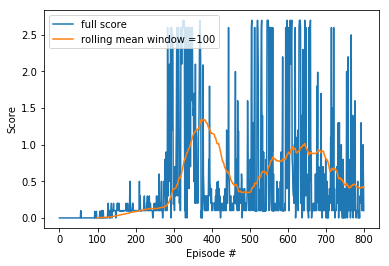

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import pandas as pd
%matplotlib inline
#i load only the first run scores, 
path_scores = 'data/scores_1.txt'
rolling_window = 100
with open(path_scores) as f:
    array_scores = np.array([float(item) for item in f.readlines()])

rolling_mean = pd.Series(array_scores).rolling(rolling_window).mean()
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(array_scores)), array_scores, label='full score')
plt.plot(np.arange(len(rolling_mean)), rolling_mean, label='rolling mean window =100')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

## MODEL
- - The final model is stored in  the model folder :
    - first_checkpoint_agent_1_version_1.pth (first model with Average Score of 0.50),
    - first_checkpoint_agent_2_version_1.pth (first model with Average Score of 0.50),
    - best_checkpoint_agent_1_version_1.pth (best model with Average Score of 1.35),
    - best_checkpoint_agent_1_version_1.pth (best model with Average Score of 1.35),

## Video
- Video with Agent in action : https://www.youtube.com/watch?v=jtyQqDcZgRs

## Future works:
- The exploration eps can really change the performance, now the scale parameter is following a deterministic law (decay the value each time stamps), it will be interesting to use another the network to learn the best eps value given the context.
- I have observed in the simulations that sometimes the actions are stacked in the same positions, it will be interesting to 6 outputs in the actor network, two related to the absolute values of each action and the other four to output the probability to select positive or negative direction for each action. In this case we can still use ReLu and separate the learning of force values from their directions.
- Another approach for action exploration using [OpenAI approach](https://blog.openai.com/better-exploration-with-parameter-noise/) or noise netoworks as explanined [here](https://youtu.be/L6xaQ501jEs?t=3046)

## Credits
- https://github.com/hortovanyi/DRLND-Collab-Compete
- https://github.com/RitwikSaikia/drlnd_p3_colab_compete
- Slack channel of the course :https://drlnd.slack.com/messages/CBMKK16DR/convo/CBMNKQ6R0-1538937877.000100/